# LSTM using Word2Vec by Sky
### 2025/5/1 11:32 pm

## 步驟1：載入套件

In [19]:
# 匯入必要的套件
import pandas as pd  # 用於資料讀取與處理
import numpy as np   # 用於數值運算
import torch         # PyTorch主套件
import torch.nn as nn  # PyTorch神經網路模組
import torch.optim as optim  # PyTorch優化器
from torch.utils.data import Dataset, DataLoader  # PyTorch資料集與資料加載器

import nltk  # 用於分詞與停用詞處理
from nltk.corpus import stopwords  # 停用詞
from nltk.tokenize import word_tokenize  # 分詞工具

import re  # 正則表達式，用於去除URL
from gensim.models import Word2Vec  # Word2Vec詞向量模型

import string  # 處理標點符號

# 下載nltk的停用詞與分詞資源（只需執行一次）
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\skych\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 步驟2：讀取資料

In [20]:
# 讀取訓練與測試資料
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

# 顯示前幾筆資料，確認欄位與內容
print("訓練資料前5筆：")
print(train_df.head())

print("\n測試資料前5筆：")
print(test_df.head())

訓練資料前5筆：
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  

測試資料前5筆：
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-0

## 步驟3：資料清理

In [21]:
import string

# 定義資料清理的函式
def clean_text(text):
    # 1. 去除URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # 2. 轉小寫
    text = text.lower()
    # 3. 去除標點符號
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 4. 分詞
    words = word_tokenize(text)
    # 5. 去除停用詞
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # 6. 移除非英文字（如數字、符號等）
    words = [word for word in words if word.isalpha()]
    return words

# 對訓練與測試資料的留言欄位進行清理與分詞
train_df['clean_tokens'] = train_df['OriginalTweet'].apply(clean_text)
test_df['clean_tokens'] = test_df['OriginalTweet'].apply(clean_text)

# 顯示清理後的結果
print("清理後的訓練資料前5筆：")
print(train_df[['OriginalTweet', 'clean_tokens']].head())

清理後的訓練資料前5筆：
                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                        clean_tokens  
0                    [menyrbie, philgahan, chrisitv]  
1  [advice, talk, neighbours, family, exchange, p...  
2  [coronavirus, australia, woolworths, give, eld...  
3  [food, stock, one, empty, please, dont, panic,...  
4  [ready, go, supermarket, outbreak, im, paranoi...  


## 步驟4：Word2Vec分詞與向量化

詞向量化後的訓練資料前5筆：
                                        clean_tokens  \
0                    [menyrbie, philgahan, chrisitv]   
1  [advice, talk, neighbours, family, exchange, p...   
2  [coronavirus, australia, woolworths, give, eld...   
3  [food, stock, one, empty, please, dont, panic,...   
4  [ready, go, supermarket, outbreak, im, paranoi...   

                                       input_indices  
0  [1, 1, 13699, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [386, 749, 2213, 168, 2599, 741, 1148, 994, 32...  
2  [2, 723, 1577, 218, 203, 1241, 1749, 11, 162, ...  
3  [3, 19, 30, 116, 33, 64, 17, 148, 3, 60, 56, 1...  
4  [598, 22, 6, 66, 107, 3808, 3, 19, 1, 116, 2, ...  


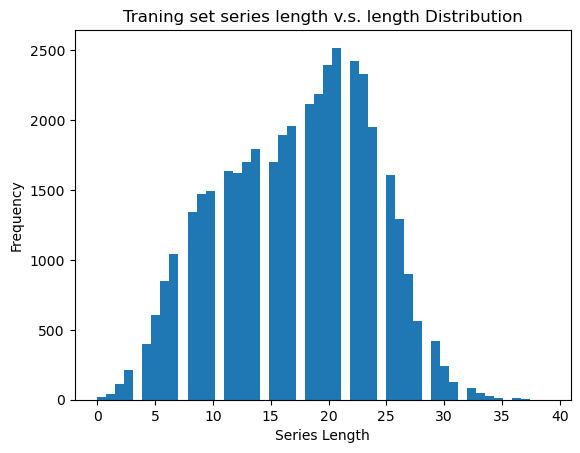

平均序列長度: 17.20
序列長度90百分位數: 25.00


In [22]:
import matplotlib.pyplot as plt
# 取得所有訓練與測試資料的分詞結果，組成一個大list（每個元素是一則留言的詞list）
all_tokens = list(train_df['clean_tokens']) + list(test_df['clean_tokens'])

# 訓練Word2Vec詞向量模型
# vector_size: 詞向量維度，可自行調整（如100、200）
# window: 上下文視窗大小
# min_count: 詞彙最少出現次數，過低會有雜訊，過高會遺漏生僻詞
w2v_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=2, workers=4)

# 建立詞彙表（word2idx）與反查表（idx2word）
word2idx = {"<PAD>": 0, "<UNK>": 1}  # PAD用於補齊，UNK用於未知詞
idx2word = {0: "<PAD>", 1: "<UNK>"}
for idx, word in enumerate(w2v_model.wv.index_to_key, start=2):
    word2idx[word] = idx
    idx2word[idx] = word

# 建立embedding矩陣，第一行是PAD，第二行是UNK（隨機初始化），其餘為Word2Vec權重
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
embedding_matrix[1] = np.random.normal(size=(embedding_dim,))  # UNK隨機初始化
for word, idx in word2idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

# 將每則留言的詞list轉為對應的index list
def tokens_to_indices(tokens, word2idx, max_len):
    # 將每個詞轉為index，若不在詞彙表則用UNK
    indices = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]
    # 補齊或截斷到max_len
    if len(indices) < max_len:
        indices += [word2idx["<PAD>"]] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

# 根據分佈調整MAX_LEN
MAX_LEN = 50  # 假設90%序列長度小於50

# 將訓練與測試資料轉為index序列
train_df['input_indices'] = train_df['clean_tokens'].apply(lambda x: tokens_to_indices(x, word2idx, MAX_LEN))
test_df['input_indices'] = test_df['clean_tokens'].apply(lambda x: tokens_to_indices(x, word2idx, MAX_LEN))

# 顯示轉換後的結果
print("詞向量化後的訓練資料前5筆：")
print(train_df[['clean_tokens', 'input_indices']].head())

# 分析clean_tokens的長度分佈
lengths = [len(tokens) for tokens in train_df['clean_tokens']]
plt.hist(lengths, bins=50)
plt.xlabel('Series Length')
plt.ylabel('Frequency')
plt.title('Traning set series length v.s. length Distribution')
plt.show()
print(f"平均序列長度: {np.mean(lengths):.2f}")
print(f"序列長度90百分位數: {np.percentile(lengths, 90):.2f}")

## 步驟5：準備PyTorch Dataset與DataLoader

In [23]:
# 先將情感標籤（Sentiment）轉為數值型label
# 這裡以五類為例：Extremely Negative, Negative, Neutral, Positive, Extremely Positive
sentiment2label = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}
train_df['label'] = train_df['Sentiment'].map(sentiment2label)
test_df['label'] = test_df['Sentiment'].map(sentiment2label)

# 建立自訂的PyTorch Dataset
class CommentDataset(Dataset):
    def __init__(self, input_indices, labels):
        self.input_indices = input_indices
        self.labels = labels

    def __len__(self):
        return len(self.input_indices)

    def __getitem__(self, idx):
        # 回傳input序列與label
        return torch.tensor(self.input_indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# 建立訓練與測試資料集
train_dataset = CommentDataset(train_df['input_indices'].tolist(), train_df['label'].tolist())
test_dataset = CommentDataset(test_df['input_indices'].tolist(), test_df['label'].tolist())

# 建立DataLoader，設定batch size
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 檢查一個batch的資料型態
for batch_inputs, batch_labels in train_loader:
    print("一個batch的input shape:", batch_inputs.shape)  # (batch_size, MAX_LEN)
    print("一個batch的label shape:", batch_labels.shape)  # (batch_size,)
    break

一個batch的input shape: torch.Size([64, 50])
一個batch的label shape: torch.Size([64])


### 檢查資料不平衡

In [24]:
# 顯示訓練集各類別分布
print("訓練集情感分布：")
print(train_df['label'].value_counts())

訓練集情感分布：
3    11422
1     9917
2     7713
4     6624
0     5481
Name: label, dtype: int64


### 使用加權損失（處理不平衡）

In [25]:
# 若資料不平衡，計算每個類別的權重
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# 使用加權損失
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.6.0+cu118
True


## 步驟5.5：超參數調優

In [18]:
# 匯入必要的套件
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid

# 檢查設備
device = torch.device("cuda")
print(f"使用設備: {device}")

# Define BiLSTMClassifier class (copied from your Step 6)
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_tensor.shape
        # Embedding layer, using pre-trained word vectors, allow fine-tuning
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim*2)
        # Take the last output of the bidirectional LSTM
        out_forward = lstm_out[:, -1, :self.lstm.hidden_size]
        out_backward = lstm_out[:, 0, self.lstm.hidden_size:]
        out = torch.cat((out_forward, out_backward), dim=1)  # (batch_size, hidden_dim*2)
        out = self.bn(out)
        out = self.dropout(out)
        logits = self.fc(out)  # (batch_size, output_dim)
        return logits


# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'hidden_dim': [128, 256],
    'dropout': [0.3, 0.5],
    'batch_size': [32, 64],
    'num_layers': [1, 2]  # Added to match your BiLSTMClassifier
}

# Function to train and evaluate model
def train_and_evaluate(params, train_loader, val_loader, embedding_tensor, output_dim, device, class_weights):
    model = BiLSTMClassifier(
        embedding_tensor=embedding_tensor,
        hidden_dim=params['hidden_dim'],
        output_dim=output_dim,
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    best_val_acc = 0
    for epoch in range(5):  # Reduced epochs for tuning
        model.train()
        total_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} 訓練中", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = val_correct / total
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
    
    return best_val_acc

# Create a validation set by splitting train_dataset (optional)
from torch.utils.data import SubsetRandomSampler
import numpy as np

# Define validation split
val_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_size = int(val_split * dataset_size)
train_indices, val_indices = indices[val_size:], indices[:val_size]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders with dynamic batch_size
best_acc = 0
best_params = None
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)
output_dim = 5  # From your notebook (5 sentiment classes)

for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    # Create data loaders with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=train_sampler)
    val_loader = DataLoader(train_dataset, batch_size=params['batch_size'], sampler=val_sampler)
    val_acc = train_and_evaluate(
        params, 
        train_loader, 
        val_loader, 
        embedding_tensor, 
        output_dim, 
        device, 
        class_weights
    )
    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params

print(f"Best parameters: {best_params}, Validation Accuracy: {best_acc}")

# Update BATCH_SIZE, HIDDEN_DIM, DROPOUT, NUM_LAYERS with best parameters
BATCH_SIZE = best_params['batch_size']
HIDDEN_DIM = best_params['hidden_dim']
DROPOUT = best_params['dropout']
NUM_LAYERS = best_params['num_layers']
print(f"Updated parameters: BATCH_SIZE={BATCH_SIZE}, HIDDEN_DIM={HIDDEN_DIM}, DROPOUT={DROPOUT}, NUM_LAYERS={NUM_LAYERS}")

使用設備: cuda
Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 32, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.3, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_layers': 2}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 1}


Testing params: {'batch_size': 64, 'dropout': 0.5, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_layers': 2}


Best parameters: {'batch_size': 32, 'dropout': 0.3, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_layers': 1}, Validation Accuracy: 0.7031952375167051
Updated parameters: BATCH_SIZE=32, HIDDEN_DIM=128, DROPOUT=0.3, NUM_LAYERS=1


## 步驟六：建立BiLSTM 模型

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

# 使用最佳參數配置 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 定義改進的 BiLSTMClassifier 模型，融入 BiLSTM 的特點
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_tensor, hidden_dim, output_dim, num_layers=2, dropout=0.2, use_hidden_states=False):
        super(BiLSTMClassifier, self).__init__()
        vocab_size, embedding_dim = embedding_tensor.shape
        # Embedding 層：使用預訓練的 Word2Vec 詞向量，允許微調
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=False)
        # 雙向 LSTM 層
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Batch Normalization 層
        self.bn = nn.BatchNorm1d(hidden_dim * 2)
        # 全連接層
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.use_hidden_states = use_hidden_states  # 控制是否使用隱藏狀態（如 BiLSTM）

    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)  # 加入嵌入層的 dropout（如 BiLSTM）
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_len, hidden_dim*2)
        
        if self.use_hidden_states:
            # 使用隱藏狀態（如 BiLSTM）
            out = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim*2)
        else:
            # 使用序列輸出（原始方式）
            out_forward = lstm_out[:, -1, :self.lstm.hidden_size]
            out_backward = lstm_out[:, 0, self.lstm.hidden_size:]
            out = torch.cat((out_forward, out_backward), dim=1)  # (batch_size, hidden_dim*2)
        
        out = self.bn(out)
        out = self.dropout(out)
        logits = self.fc(out)  # (batch_size, output_dim)
        return logits

# 設定模型參數（使用超參數調優結果）
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float).to(device)
OUTPUT_DIM = 5  # 情感分類數量（固定為5類）
model = BiLSTMClassifier(
    embedding_tensor=embedding_tensor,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    use_hidden_states=False  # 默認使用原始序列輸出，設為 True 可測試 BiLSTM 方式
).to(device)
print(model)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# 定義訓練函數
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc="訓練中", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# 定義驗證函數
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

# 早停機制
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0

# 訓練主流程
EPOCHS = 20
train_losses = []
val_losses = []
val_accuracies = []
early_stopping = EarlyStopping(patience=3)

for epoch in range(EPOCHS):
    print(f"\n==== 第{epoch+1}輪訓練 ====")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"訓練損失={train_loss:.4f}，驗證損失={val_loss:.4f}，驗證準確率={val_acc:.4f}")
    
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"早停觸發，停止於第{epoch+1}輪")
        break

BiLSTMClassifier(
  (embedding): Embedding(23133, 100)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

==== 第1輪訓練 ====


訓練損失=1.3281，驗證損失=1.0891，驗證準確率=0.4781

==== 第2輪訓練 ====


訓練損失=0.8896，驗證損失=0.8955，驗證準確率=0.6535

==== 第3輪訓練 ====


訓練損失=0.6497，驗證損失=0.8579，驗證準確率=0.6875

==== 第4輪訓練 ====


訓練損失=0.5277，驗證損失=0.8513，驗證準確率=0.6788

==== 第5輪訓練 ====


訓練損失=0.4375，驗證損失=1.0008，驗證準確率=0.6790

==== 第6輪訓練 ====


訓練損失=0.3635，驗證損失=1.0160，驗證準確率=0.6785

==== 第7輪訓練 ====


訓練損失=0.3040，驗證損失=1.1505，驗證準確率=0.6701
早停觸發，停止於第7輪


## 步驟七：視覺化訓練結果

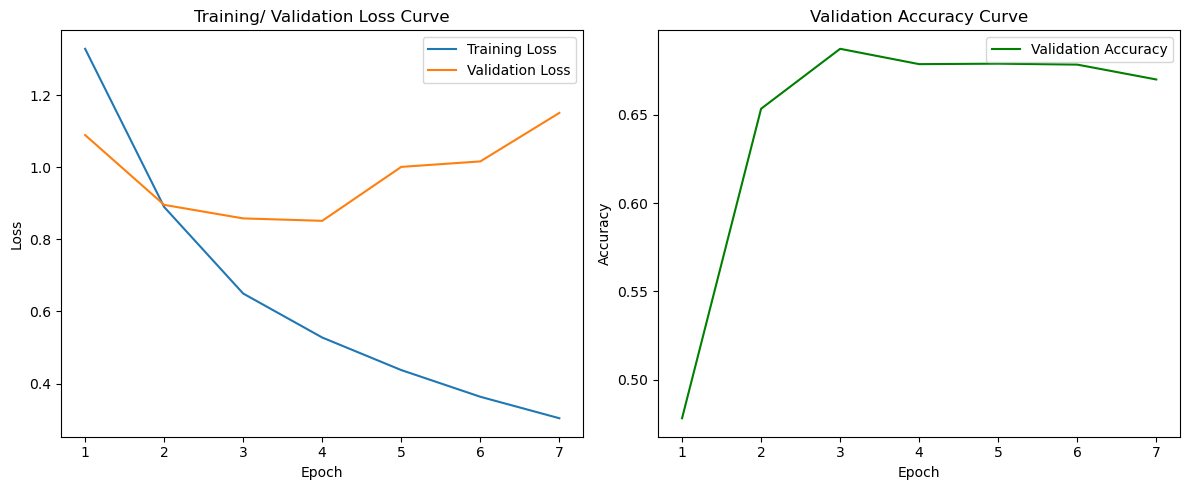

最終模型已儲存至 final_lstm_model.pth


In [35]:
# 視覺化訓練過程
plt.figure(figsize=(12,5))
# 繪製損失曲線
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/ Validation Loss Curve')
plt.legend()
# 繪製準確率曲線
plt.subplot(1,2,2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')  # 儲存圖表
plt.show()

# 儲存最終模型
torch.save(model.state_dict(), "final_lstm_model.pth")
print("最終模型已儲存至 final_lstm_model.pth")